In [19]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

import pandas as pd
from random import random

%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1234)



Using Theano backend.


    Unnamed: 0  accelerationX  accelerationY  accelerationZ  timestamp  \
0          614         -0.229          5.909          9.232          0   
1          621         -0.306          6.704          7.834         60   
2           63         -0.383          6.771          6.799        121   
3          642         -0.162          6.416          7.010        183   
4          655         -0.249          6.445          6.962        241   
5          674         -0.450          6.493          7.336        300   
6          681         -0.325          6.627          6.818        360   
7           69         -0.114          6.732          6.847        420   
8          702         -0.459          6.598          7.412        484   
9         7115          0.057          6.359          7.834        540   
10          73          0.296          6.464          7.326        601   
11         743         -0.526          7.288          5.142        668   
12         756          0.545         

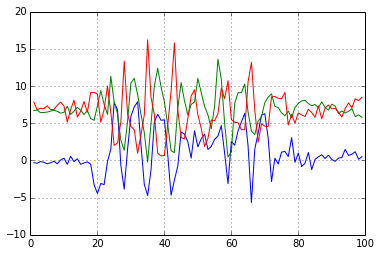

In [24]:
data = pd.read_csv("accelData.csv")
print data

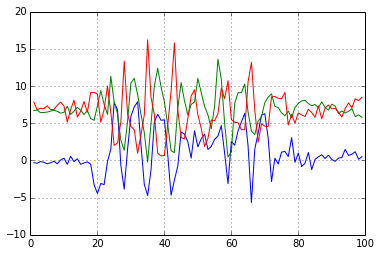

In [25]:
plt.figure()
data.accelerationX[1:100].plot()
data.accelerationY[1:100].plot()
data.accelerationZ[1:100].plot()

In [38]:
dumAct = pd.get_dummies(data.Activity)
dumSoc = pd.get_dummies(data.Social)
datadum = pd.concat([data, dumAct, dumSoc], axis=1)
#print datadum
datadum.describe()


,Unnamed: 0,accelerationX,accelerationY,accelerationZ,timestamp,timestamp.orig,EXP,MON,OFF,QUE,REP,TDT,TEC,CLS,GRP,IND
count,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,5.056930e+05,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000,505693.000000
mean,413918.516456,4.282371,-0.499722,-0.149098,1306683.495740,1.443357e+12,0.131641,0.267801,0.001995,0.080885,0.153846,0.067246,0.028333,0.467639,0.128303,0.159460
std,458067.116533,6.550592,5.514142,2.342199,792163.519801,6.728403e+09,0.338101,0.442814,0.044624,0.272659,0.360802,0.250448,0.165924,0.498952,0.334427,0.366105
min,1.000000,-19.499001,-19.499001,-19.775999,0.000000,1.433229e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,141002.000000,-1.130000,-1.790000,-1.474000,635280.000000,1.433252e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,350265.000000,8.878000,-0.076000,-0.239000,1270700.000000,1.447403e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,566094.000000,9.510000,1.426000,0.900000,1925380.000000,1.448012e+12,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,8018110.000000,19.719000,19.719000,19.441000,3252073.000000,1.448618e+12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# We test with one session of each teacher
test = datadum.loc[datadum['session'].isin(['case1-day1-session1-teacher1','case2-day1-session1-teacher2'])]
test.describe()


,Unnamed: 0,accelerationX,accelerationY,accelerationZ,timestamp,timestamp.orig,EXP,MON,OFF,QUE,REP,TDT,TEC,CLS,GRP,IND
count,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,6.872500e+04,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000,68725.000000
mean,149356.764889,3.544108,-0.225983,-0.699170,1063026.951793,1.438848e+12,0.106686,0.217461,0.004380,0.075053,0.154383,0.119447,0.049924,0.438341,0.203710,0.087086
std,174750.194199,5.034092,7.507800,2.184208,642165.728676,6.682931e+09,0.308716,0.412522,0.066035,0.263478,0.361319,0.324316,0.217789,0.496187,0.402759,0.281963
min,1.000000,-16.645000,-19.499001,-19.622999,0.000000,1.433229e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25096.000000,-1.043000,-9.404000,-1.685000,518807.000000,1.433230e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51186.000000,1.350000,0.134000,-0.430000,1034649.000000,1.433232e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,262273.000000,9.462000,8.236000,0.363000,1550609.000000,1.446798e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,619712.000000,19.671000,19.719000,19.115000,2404761.000000,1.446799e+12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
# We train with the rest of sessions of both teachers
train = datadum.loc[np.logical_not(datadum['session'].isin(['case1-day1-session1-teacher1','case2-day1-session1-teacher2']))]
train.describe()

,Unnamed: 0,accelerationX,accelerationY,accelerationZ,timestamp,timestamp.orig,EXP,MON,OFF,QUE,REP,TDT,TEC,CLS,GRP,IND
count,436968.000000,436968.000000,436968.000000,436968.000000,436968.000000,4.369680e+05,436968.000000,436968.000000,436968.00000,436968.000000,436968.000000,436968.000000,436968.000000,436968.000000,436968.000000,436968.000000
mean,455527.985287,4.398483,-0.542775,-0.062585,1345005.057004,1.444066e+12,0.135566,0.275718,0.00162,0.081802,0.153762,0.059036,0.024938,0.472247,0.116443,0.170843
std,474640.722730,6.750865,5.129242,2.354423,806570.357282,6.454947e+09,0.342328,0.446876,0.04022,0.274064,0.360721,0.235693,0.155936,0.499230,0.320756,0.376372
min,6.000000,-19.499001,-19.499001,-19.775999,0.000000,1.433236e+12,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,193008.250000,-1.149000,-1.685000,-1.446000,658598.750000,1.433253e+12,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,390067.500000,9.021000,-0.153000,-0.201000,1318921.000000,1.447407e+12,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,602191.250000,9.519000,1.312000,1.091000,1979680.250000,1.448013e+12,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,8018110.000000,19.719000,19.719000,19.441000,3252073.000000,1.448618e+12,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
#TODO: split into train and test sets
#Follow/mix:
#https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
#https://gist.github.com/hnykda/c362f0ad488e3b289394
#https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py
